<a href="https://colab.research.google.com/github/5234560002ebnida/nonfictioner/blob/main/supertrend_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Timeframe: day


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


              Close  Supertrend  Direction         Alert
Date                                                    
2012-05-17  55500.0         0.0        0.0           nan
2012-05-18  54300.0         NaN        1.0  Trend Change
2012-05-21  53600.0         NaN       -1.0  Trend Change
2012-05-22  54800.0         NaN       -1.0           nan
2012-05-23  53800.0         NaN       -1.0           nan
...             ...         ...        ...           ...
2024-07-18  48750.0     45630.0        1.0           nan
2024-07-19  47900.0     45630.0        1.0           nan
2024-07-22  48000.0     45630.0        1.0           nan
2024-07-23  47350.0     45630.0        1.0           nan
2024-07-24  46250.0     45630.0        1.0           nan

[3000 rows x 4 columns]


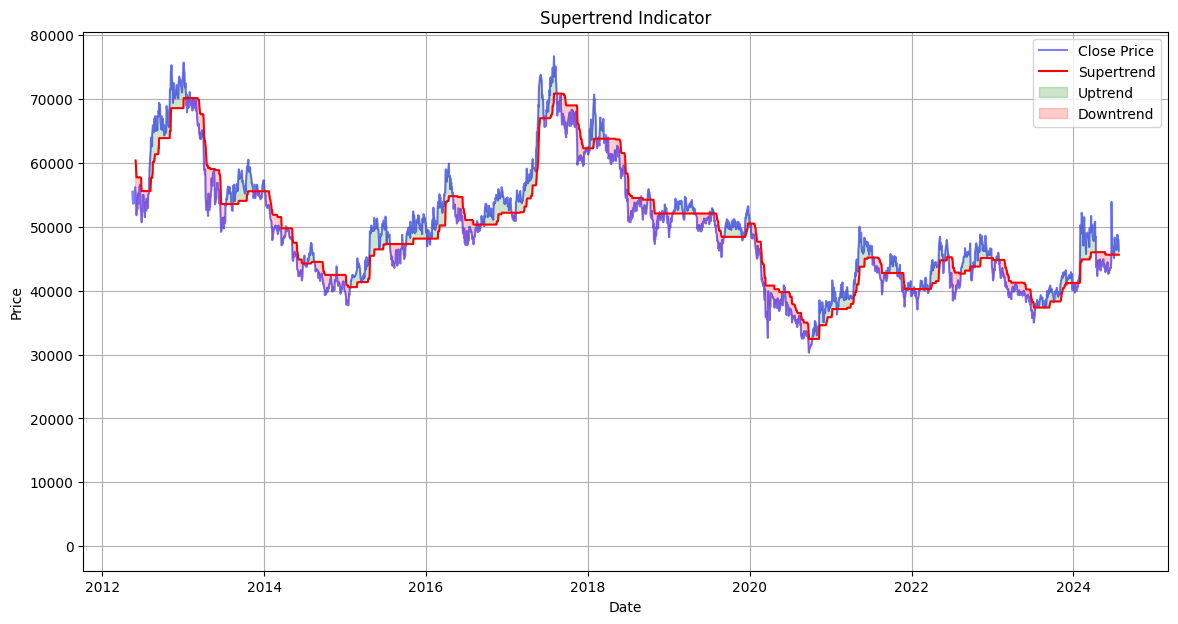


Timeframe: week


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


              Close  Supertrend  Direction         Alert
Date                                                    
2004-08-06  23400.0         0.0        0.0           nan
2004-08-13  22950.0         NaN        1.0  Trend Change
2004-08-20  22200.0         NaN       -1.0  Trend Change
2004-08-27  22300.0         NaN       -1.0           nan
2004-09-03  21500.0         NaN       -1.0           nan
...             ...         ...        ...           ...
2024-06-28  46900.0     42505.0        1.0           nan
2024-07-05  48300.0     42505.0        1.0           nan
2024-07-12  46400.0     42505.0        1.0           nan
2024-07-19  47900.0     42505.0        1.0           nan
2024-07-24  46250.0     42505.0        1.0           nan

[1042 rows x 4 columns]


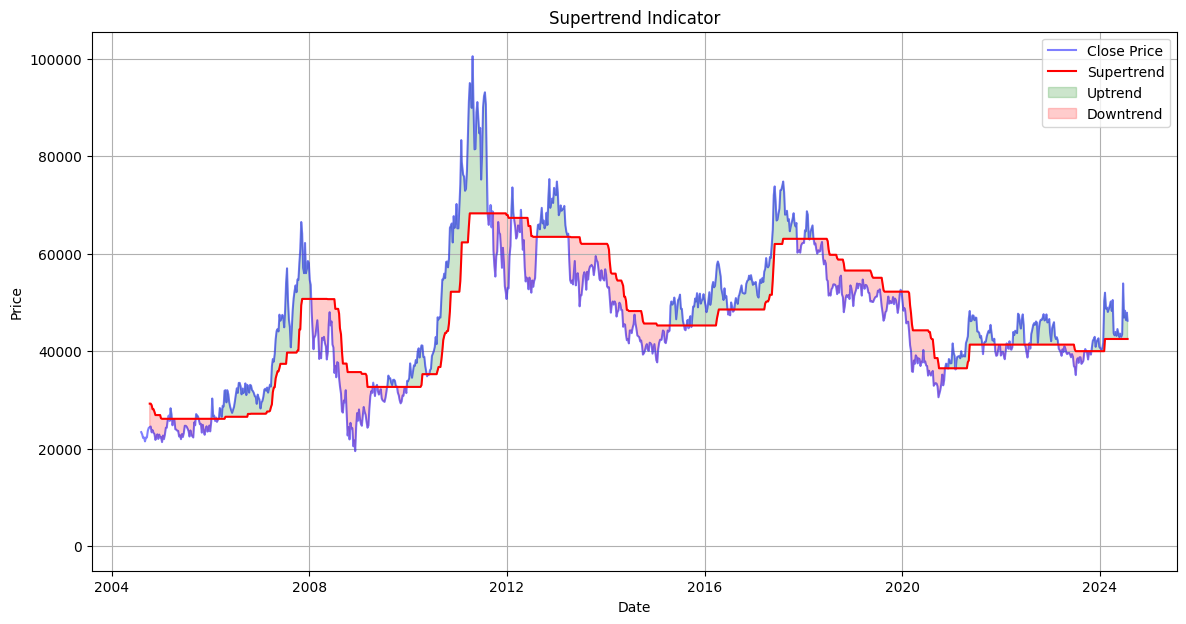


Timeframe: month


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


              Close  Supertrend  Direction         Alert
Date                                                    
2004-08-31  21600.0         0.0        0.0           nan
2004-09-30  24650.0         NaN        1.0  Trend Change
2004-10-29  23800.0         NaN       -1.0  Trend Change
2004-11-30  22550.0         NaN       -1.0           nan
2004-12-30  22400.0         NaN       -1.0           nan
...             ...         ...        ...           ...
2024-03-29  48250.0     48935.0       -1.0           nan
2024-04-30  44900.0     48935.0       -1.0           nan
2024-05-31  43600.0     48935.0       -1.0           nan
2024-06-28  46900.0     48935.0       -1.0           nan
2024-07-24  46250.0     48935.0       -1.0           nan

[240 rows x 4 columns]


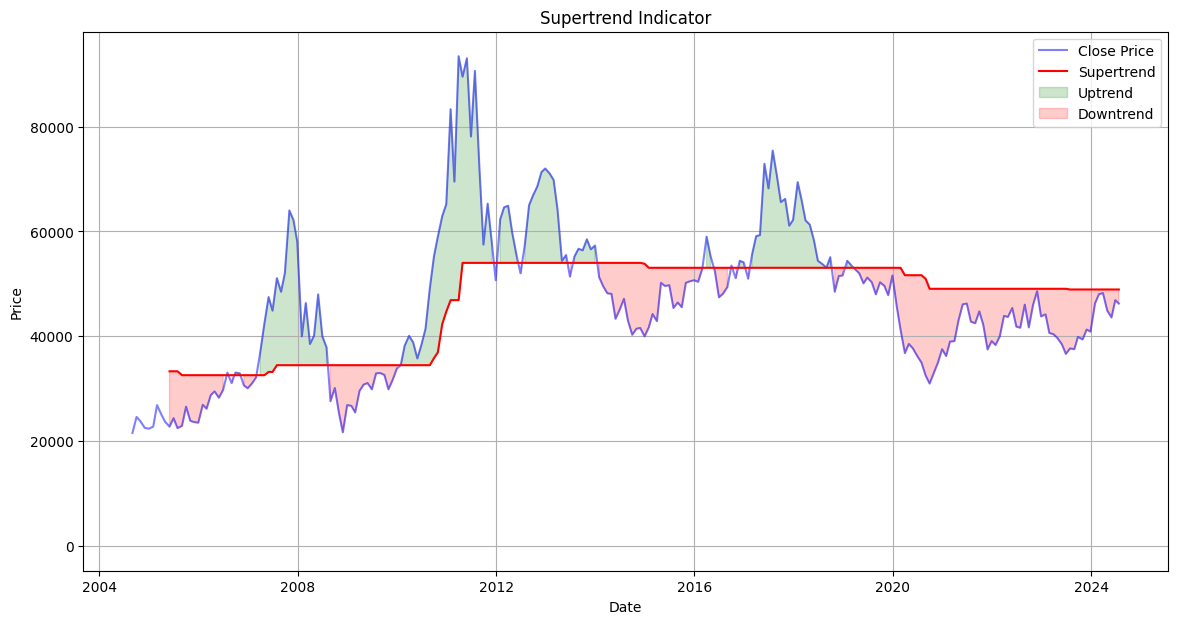

In [7]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

def get_price(symbol, startTime, endTime, timeframe='day'):
    count = 3000
    url = f"https://fchart.stock.naver.com/sise.nhn?symbol={symbol}&timeframe={timeframe}&count={count}&requestType=0"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    params = {
        'symbol': symbol,
        'requestType': 1,
        'startTime': startTime,
        'endTime': endTime,
        'timeframe': timeframe
    }

    columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = []
    items = soup.select('item')
    for item in items:
        row = item['data'].split('|')
        data.append(row)

    df = pd.DataFrame(data, columns=columns)

    # 'Date' 컬럼을 datetime으로 변환하고 인덱스로 설정
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df.astype(float)

def calculate_supertrend(data, atr_period=10, factor=3.0):
    high = data['High']
    low = data['Low']
    close = data['Close']

    # ATR 계산
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=atr_period).mean()

    # Supertrend 계산
    upperband = ((high + low) / 2) + (factor * atr)
    lowerband = ((high + low) / 2) - (factor * atr)
    supertrend = np.zeros(len(data))
    direction = np.zeros(len(data))

    for i in range(1, len(data)):
        if close[i] > supertrend[i-1]:
            supertrend[i] = max(lowerband[i], supertrend[i-1])
            direction[i] = 1  # Uptrend
        else:
            supertrend[i] = min(upperband[i], supertrend[i-1])
            direction[i] = -1  # Downtrend

    data['Supertrend'] = supertrend
    data['Direction'] = direction
    data['Trend Change'] = data['Direction'].diff().fillna(0)
    data['Alert'] = np.where(data['Trend Change'] != 0, 'Trend Change', np.nan)

    return data

def plot_supertrend(data):
    plt.figure(figsize=(14,7))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(data.index, data['Supertrend'], label='Supertrend', color='red')
    plt.fill_between(data.index, data['Close'], data['Supertrend'],
                     where=data['Direction'] == 1, color='green', alpha=0.2, label='Uptrend')
    plt.fill_between(data.index, data['Close'], data['Supertrend'],
                     where=data['Direction'] == -1, color='red', alpha=0.2, label='Downtrend')

    plt.title(f"Supertrend Indicator")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 사용 예시
symbol = '078930'  # GS종목코드
startTime = '20220501'
endTime = '20220518'

timeframes = ['day', 'week', 'month']
for timeframe in timeframes:
    print(f"\nTimeframe: {timeframe}")
    df = get_price(symbol, startTime, endTime, timeframe)
    df = calculate_supertrend(df)
    print(df[['Close', 'Supertrend', 'Direction', 'Alert']])
    plot_supertrend(df)

